# HW6
 Name: Anthony Martinezz
 PID: A13378551

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

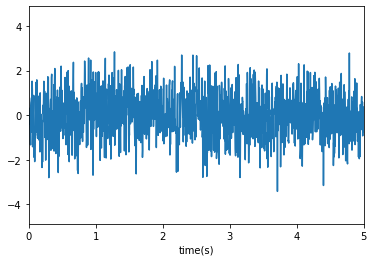

In [32]:
# 1a) Start by creating a random white-noise stimulus, s(t), by choosing values from a standard Gaussian distribution
# (mean 0 and variance 1). s(t) represents fluctuations in intensity above and below a fixed baseline. Make the 
# stimulus refresh rate 256 Hz and duration 5 minutes. Plot the stimulus, zooming in to show just the first 5 s.

Fs = 256
t_time = np.arange(0,300,1/Fs)
s = np.random.normal(0,1,len(t_time))

plt.plot(t_time,s)
plt.xlim([0,5])
plt.xlabel('time(s)')
plt.show()


In [33]:
# 1b) Now assume the RGC’s temporal receptive field is defined by a filter h(t), where tau=70 ms is 
# the time constant and R=6 Hz is the mean firing rate. Plot this impulse response function in a time window t[0,500]
# ms. This filter shape is called an alpha function. 

# h function
def h(R,dt,t,tau):
    return (R*dt) * (t/(tau**2)) * np.exp(-t/tau)

Text(0.5, 1.0, 'Alpha Function')

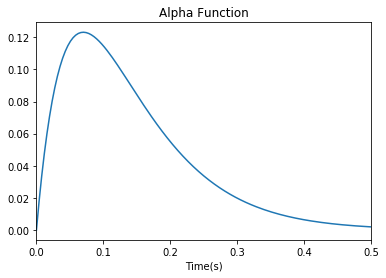

In [34]:
h = h(6,1/Fs,t_time,0.07)

plt.plot(t_time,h)
plt.xlim([0,0.5])
plt.xlabel("Time(s)")
plt.title("Alpha Function")


Text(0, 0.5, 'Power (dB)')

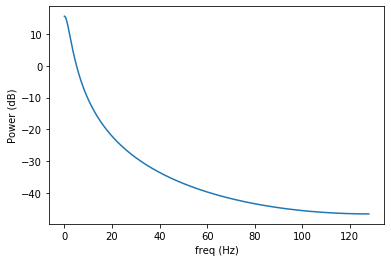

In [35]:
# 1c) What kind of filter is this (low-pass, high-pass)? Plot the squared magnitude of the transfer function
# (i.e. the power) and comment on the relationship between the cutoff frequency and tau

f = np.fft.fftfreq(len(t_time),1/Fs)
H = np.fft.fft(h)
power = np.abs(H)**2


plt.plot(f[f>0], 10 * np.log10(power[f>0]), '-')
#plt.xlim([0,50])
plt.xlabel('freq (Hz)')
plt.ylabel('Power (dB)')

# This is a low pass filter

Text(0, 0.5, 'Firing Rate')

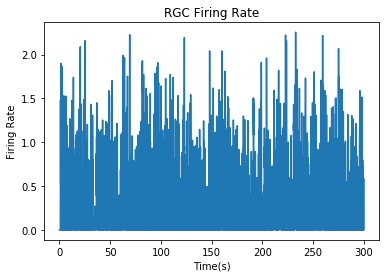

In [36]:
# 1d) now convolve s(t) with h(t) and apply a “rectifying” nonlinearity (i.e. F[x]=(x,0)) to produce 
# r(t)=F[s(t)h(t)]. This is the RGC’s firing rate as a function of time.
S = np.fft.fft(s)
H = np.fft.fft(h)
R = S*H
r = np.fft.ifft(R)
r = r*(r>0)

plt.plot(t_time,r)
plt.xlabel("Time(s)")
plt.title("RGC Firing Rate")
plt.ylabel("Firing Rate")

Text(0.5, 0, 'Time(s)')

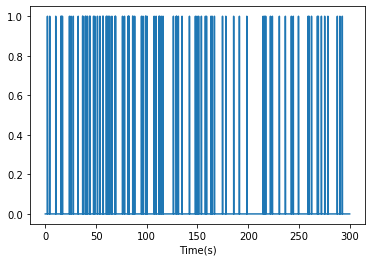

In [37]:
# 1e) Simulate a Poisson spike train, q(t), with rate r(t). Use the same method as in HW5, problem 2, to represent 
# q(t) as a vector of zeros and ones with the same size as s(t). 

dt = 1/Fs
q = np.random.rand(len(t_time)) < r*dt

plt.plot(t_time, q)
plt.xlabel("Time(s)")

Text(0.5, 0, 'Time(s)')

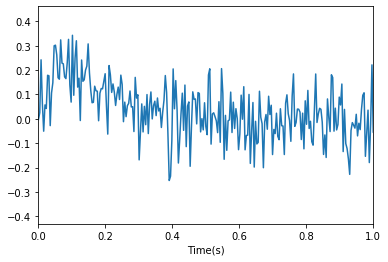

In [38]:
# 1f) Compute the reverse-correlation, hest(t), i.e. the convolution of the spike train (t) with the time-reversed
# stimulus s(-t). Divide by the number of spikes (i.e. t(t)) to obtain an estimate, hest, of the cell’s filter, h. 
# Plot hest(t). (NOTE: You should zoom in to show the first 1 s of the filter, which contains the relevant part)

s_neg = s[::-1]
S_neg = np.fft.fft(s_neg)
Q = np.fft.fft(q)
H_est = S_neg*Q
h_est = np.fft.ifft(H_est)
h_est = h_est/np.count_nonzero(q)

plt.plot(t_time,h_est)
plt.xlim([0,1])
plt.xlabel("Time(s)")

Text(0, 0.5, 'Firing Rate')

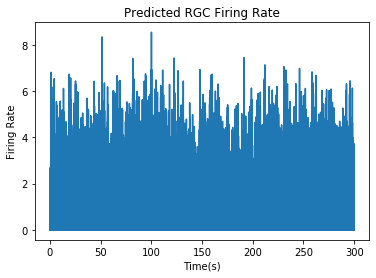

In [39]:
# 1g) Convolve the estimated filter, hest, with s, and apply the rectification (i.e. set negative values to 0) to
# produce a predicted spike rate, rest(t). Compare this estimate with the true spike rate, r(t). (Hint: Note that the
# estimated filter hest(t) is noisy, and this noise could dominate your results. To reduce the noise, set hest(t)=0 
# for t>1s.)

h_est_t = (t_time<1)*h_est
H_est_t = np.fft.fft(h_est_t)
R_est = H_est_t * S
r_est = np.fft.ifft(R_est)
r_est = r_est * (r_est>0)

plt.plot(t_time,r_est)
plt.xlabel("Time(s)")
plt.title("Predicted RGC Firing Rate")
plt.ylabel("Firing Rate")

# The predicted spike rate is much higher than the actual spike rate

Text(0.5, 0, 'Time(s)')

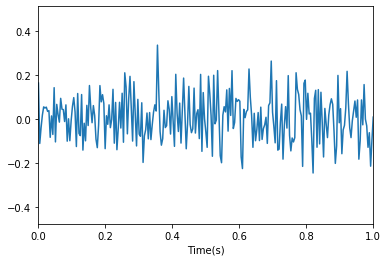

In [40]:
# 2a) Randomize (or “shuffle”) the spike times and compute the reverse-correlation of the original stimulus
# with the shuffled spikes. Hint: Use numpy.random.permutation.

shuf_spike = np.random.permutation(q)
Shuf_spike = np.fft.fft(shuf_spike)
H_new = S_neg * Shuf_spike
h_new = np.fft.ifft(H_new)
h_new = h_new/np.count_nonzero(shuf_spike)

plt.plot(t_time, h_new)
plt.xlim([0,1])
plt.xlabel("Time(s)")

In [41]:
# 2b) Repeat the randomization and rev-corr computation 500 times and store all of the resulting reverse 
#correlations. The result will be a matrix, hshuff[t,j], where j[1,500] is the index of the shuffles. 

nshuff=500
h_shuff = []
for i in range(nshuff):
    shuf_spike = np.random.permutation(q)
    Shuf_spike = np.fft.fft(shuf_spike)
    H_new = S_neg * Shuf_spike
    h_new = np.fft.ifft(H_new)
    h_new = h_new/np.count_nonzero(shuf_spike)
    h_shuff.append(h_new)
    
h_shuff = np.asarray(h_shuff)    

Text(0, 0.5, '-log10(p(t))')

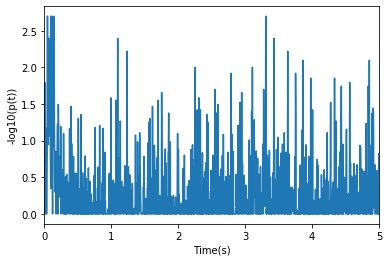

In [42]:
# 2c) At each time bin (t), define the empirical p-value as the percentage of shuffled rev-corr functions with
#absolute magnitude greater than or equal to the rev-corr of the original (unshuffled) data.  That is, p(t)=1500
#[#{j such that |hest(t)| < |hshuff(t,j)|}+1] .

p_shuff = (np.sum( h_shuff > h_est )+1)/nshuff
p = []

for i in range(len(t_time)):
    p.append(1/nshuff*((np.abs(h_est[i]<np.abs(h_shuff[:,i])).sum()+1)))
    
p = np.asarray(p)

plt.plot(t_time,-np.log10(p))
plt.xlim([0,5])
plt.xlabel("Time(s)")
plt.ylabel("-log10(p(t))")

In [44]:
# 2d) Considering all of the 256 time bins for t[0,1 s], how many would you expect to show p value < 0.05 under
# the null hypothesis of no correlation? How many time bins actually do pass this p-value threshold?

#first 256 time bins of p
p_star = p[0:256,]

#all instances where p_star is under the threshold
result = [i for i in p_star if i < 0.05]
print(result)
#number of pvalues that are under the threshold
count = np.count_nonzero(result)
print(count)
print("There are 20 bins that pass the pvalue threshold in t[0,1s]")
print("However, we would expect ~13 bins to pass the pvalue threshold")

[0.016, 0.002, 0.002, 0.01, 0.004, 0.03, 0.022, 0.018000000000000002, 0.004, 0.002, 0.016, 0.002, 0.016, 0.02, 0.026000000000000002, 0.002, 0.032, 0.034, 0.044, 0.026000000000000002]
20
There are 20 bins that pass the pvalue threshold in t[0,1s]
However, we would expect ~13 bins to pass the pvalue threshold


In [45]:
#all instances where p_star is under bonferroni threshold
result = [i for i in p if i < 0.0001]
print(result)
#number of pvalues that are under the threshold
count = np.count_nonzero(result)
print(count)

[]
0
